In [1]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
%matplotlib inline

## Load and clean the data

In [2]:
df = pd.read_csv('../data/tweets_labelled.csv')

# select the attack and text columns
df = df[['attack', 'text']]

# drop rows with nan values
df = df.dropna()

# drop any with all white-space text
df.text = df.text.str.strip()
df = df[df.text!='']

# convert the attack column to an integer
df.attack = df.attack.astype('int')

## Look at the data

In [3]:
df.head()

,attack,text
0,0,Today I introduced the Addressing Teacher Shor...
1,1,Wholeheartedly agree .@RepJeffries -- McConnel...
2,0,Look forward to reading it. Thanks!
3,0,"When we passed the Tax Cuts and Jobs Act, it h..."
4,1,There's still time for an @FBI background inve...


In [4]:
# look at number of attacks.
# 0: not attack
# 1: attack
df.groupby('attack').count()

,text
attack,
0,1110
1,165


Note that there are many more _non-attacks_ than _attacks_. This is called class imbalance and can lead to challenges for modeling and model evaluation.

In [5]:
# show ten random tweets
list(df.sample(10, replace=False).text)

['@CaseyNeistat yo casey. We need you to spread whats happening in Kerala, India. #DoForKerala #kerala @mkbhd @Dannmace @elonmuskpic.twitter.com/r4l2VyKBfk',
 'I sat in on interviews w/students pursuing a nomination to a US service academy. I was impressed by their patriotism & commitment #PA11#NEPA',
 'Wanted to use my first speaking opportunity on the House Floor to say #ThankYou to #Michigan1 for the opportunity to serve you in Congress.pic.twitter.com/3gFn6akSeU',
 "Honored to join @GovernorVA McAuliffe today for a faith leaders reception at the Governor's Mansion.pic.twitter.com/gav7TPIrC4",
 'The House just said #Yes2Energy by passing HR 351, increasing our Natural Gas Exports!pic.twitter.com/8BVjg0LSJp',
 'La preparaci\\xc3\\xb3n acad\\xc3\\xa9mica de los beneficiarios de #DACA estimula la actividad econ\\xc3\\xb3mica en todo el pa\\xc3\\xads.pic.twitter.com/tejgV10idl',
 'RT @GOPLeader: The House passed the Gabriella Miller #KidsFirst Research Act in a 295-103 vote:pic.twitter.

## Preprocess text
Preprocessing is one of the subtlest parts of natural language processing. For brevity, we perform only the most basic steps. 

In [6]:
# replace all punctuation with space
def remove_punctuation(txt):
    txt = txt.translate(None, string.punctuation)
    
    return txt

# lowercase text
def lowercase(txt):
    txt = txt.lower()
    # TODO: more nuanced rules...
    return txt

# remove stopwords
def remove_stopwords(txt):
    stop_words = set(stopwords.words('english')) 
    toks = word_tokenize(txt) 
    toks = [w for w in toks if not w in stop_words]
    txt = " ".join(toks)
    
    return txt

# TODO: perform other steps...

# put all steps together
def preproc(txt):
    txt = remove_punctuation(txt)
    txt = lowercase(txt)
    txt = remove_stopwords(txt)
    #TODO: other steps...
    
    return txt    

In [7]:
# try it out on some text
preproc("Why are the lights SOOOOO bright")

'lights sooooo bright'

In [8]:
# Apply the preprocessing to our text
df['text_proc'] = df.text.apply(lambda txt: preproc(txt))

In [9]:
# Take a look at the processed txt
df.sample(20, replace=False)[['text', 'text_proc']]

,text,text_proc
335,"President Obama was right to protect 750,000 y...",president obama right protect 750000 young men...
1088,I just met with the @EnidChamber in Washington...,met enidchamber washington dc great discuss is...
21,Apple analyst: 'We put too much emphasis on th...,apple analyst put much emphasis iphone super e...
976,Via @WSJ: National Lampoon's ObamaCare Vacatio...,via wsj national lampoons obamacare vacation h...
247,Busy day at the @CFPB. Digging into the detail...,busy day cfpb digging detailspictwittercomyfs0...
756,Want to see my #TBT photo? Follow me on Intsta...,want see tbt photo follow intstagram httpwwwin...
271,Glad I had the chance to catch up with Shirley...,glad chance catch shirley odegaard shes active...
128,Take time this #NationalParkWeek to get outsid...,take time nationalparkweek get outside findyou...
442,It's great to be in Holly Springs to talk with...,great holly springs talk rotarians including g...
931,ICYMI: Was an honor to be at @WhiteHouse to se...,icymi honor whitehouse see president take acti...


## Bag of words model

In [10]:
# select data for modeling
y = df['attack']
X = df['text_proc'] 

In [11]:
# get count features
count_vect = CountVectorizer(
    ngram_range=(1,2),
    strip_accents='unicode',
    min_df = 5
    )
X_counts = count_vect.fit_transform(X)
X_counts.shape 

(1275, 609)

In [12]:
# hold-out some data for final validation
X_counts_train, X_counts_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.25, random_state=42)

In [13]:
# Define and fit the model
estimator =  LogisticRegression()
params = dict(C=[10,3,1,0.3,0.1])
clf_cv = GridSearchCV(estimator, param_grid=params, cv=8, verbose=5, n_jobs=6, return_train_score=True)
print(clf_cv.fit(X_counts_train, y_train))

Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.7s


GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'C': [10, 3, 1, 0.3, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=5)


[Parallel(n_jobs=6)]: Done  38 out of  40 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    2.0s finished
/home/hudson/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
# raw cross-validation results
res = clf_cv.cv_results_
res

{'mean_fit_time': array([0.00398257, 0.00303167, 0.002657  , 0.00243115, 0.00244147]),
 'mean_score_time': array([0.00048882, 0.00040597, 0.00037399, 0.00038096, 0.00041655]),
 'mean_test_score': array([0.87656904, 0.88179916, 0.87343096, 0.87343096, 0.87343096]),
 'mean_train_score': array([0.97683898, 0.91616966, 0.87686853, 0.87343114, 0.87343114]),
 'param_C': masked_array(data=[10, 3, 1, 0.3, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10}, {'C': 3}, {'C': 1}, {'C': 0.3}, {'C': 0.1}],
 'rank_test_score': array([2, 1, 3, 3, 3], dtype=int32),
 'split0_test_score': array([0.85123967, 0.8677686 , 0.8677686 , 0.8677686 , 0.8677686 ]),
 'split0_train_score': array([0.98083832, 0.92335329, 0.88023952, 0.8742515 , 0.8742515 ]),
 'split1_test_score': array([0.86666667, 0.875     , 0.875     , 0.875     , 0.875     ]),
 'split1_train_score': array([0.9784689 , 0.91626794, 0.87679426, 0.87320574, 0.873205

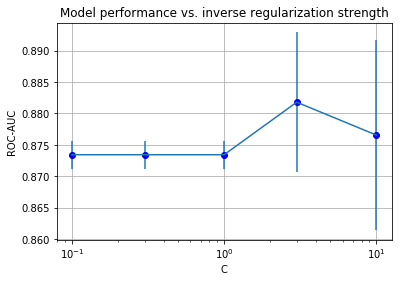

In [15]:
import matplotlib.pyplot as plt
plt.semilogx(params['C'], res['mean_test_score'], 'bo')
plt.errorbar(params['C'], res['mean_test_score'], yerr=res['std_test_score'])
plt.title('Model performance vs. inverse regularization strength')
plt.xlabel('C')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

## Evaluate model

In [16]:
# Retrain best model on entire training set and predict outcomes on test set
from sklearn import metrics
clf_best = clf_cv.best_estimator_.fit(X_counts_train, y_train)
y_pred_test = clf_best.predict_proba(X_counts_test)[:,1]

Maximum F1 score: 0.5714285714285714
Precision at max: 0.7692307692307693
Recall at max: 0.45454545454545453
Optimal threshold: 0.28527029374856383
Confusion matrix: 
[[269   6]
 [ 25  19]]


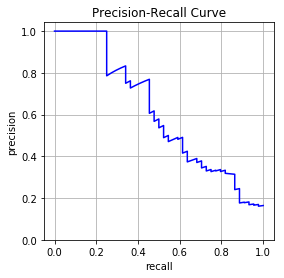

<Figure size 432x288 with 0 Axes>

In [17]:
# precision-recall analysis:
precision, recall, eps = metrics.precision_recall_curve(y_test, y_pred_test)
f1 = 2 * precision * recall / (precision + recall)
f1max_ind = np.argmax(f1)
print("Maximum F1 score: " + str(f1[f1max_ind]))
print("Precision at max: " + str(precision[f1max_ind]))
print("Recall at max: " + str(recall[f1max_ind]))
print("Optimal threshold: " + str(eps[f1max_ind]))

# confusion matrix at optimal threshold
print "Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred_test>eps[f1max_ind])

# precision recall curve
fig, ax = plt.subplots() 
ax.plot(recall, precision, 'b-')
ax.set(xlabel='recall', ylabel='precision',ylim=(0,None))
ax.set_aspect('equal')
ax.grid()
plt.title('Precision-Recall Curve')
plt.show()
plt.clf()

ROC-AUC:  0.8350413223140496


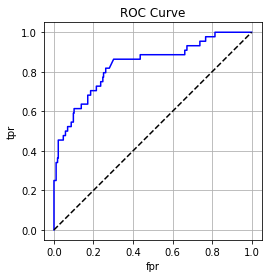

<Figure size 432x288 with 0 Axes>

In [31]:
# ROC Analysis:
fpr, tpr, th = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_test)
print "ROC-AUC: ", roc_auc

fig, ax = plt.subplots() 
ax.plot(fpr, tpr, 'b-')
ax.plot([0,1],[0,1],'k--')
#ax.plot([0,0.5],[1,0.5], 'k-')
#ax.plot([0,0.3],[1,1],'k',linewidth=10)
#ax.plot([0],[1],'ro',markersize=20)
ax.set(xlabel='fpr', ylabel='tpr')
ax.set_aspect('equal')
ax.grid()
plt.title("ROC Curve")
plt.show()
plt.clf()

## What words are important?

In [19]:
# find coefficient size order from min to max
argsrt = np.argsort(clf_best.coef_).flatten()

# map to words
sorted_words = np.asarray(count_vect.vocabulary_.keys())[argsrt]

In [20]:
# top words predicting attack:
n=25
print "Attack words: ", sorted_words[-1:-1*n-1:-1]

# predicting not attack:
print "Non-attack words: ", sorted_words[0:n]

Attack words:  [u'receive' u'association' u'balanced' u'dangerous' u'residents' u'stay'
 u'epa' u'ill' u'attending' u'congress' u'tax cuts' u'discussion'
 u'release' u'great' u'constituents' u'town hall' u'americas' u'hard'
 u'joining' u'cuts jobs' u'afternoon' u'security' u'glad' u'lives'
 u'interest']
Non-attack words:  [u'dont' u'dc' u'presidents' u'sure' u'ways' u'big' u'helping'
 u'protection' u'prevent' u'interview' u'gives' u'discuss' u'jobs' u'sotu'
 u'proud' u'way' u'tweet' u'efforts' u'defend' u'cut' u'mental'
 u'medicare' u'news' u'put' u'watch']


## What are examples where the model got it wrong?

In [50]:
# Predicted attack but wasn't:
idx=np.logical_and(y_pred_test>eps[f1max_ind], y_test!=1)
idx=idx[idx].index
list(df.loc[idx].text)

['"We will block the Administration\\\'s war on all forms of energy in this country. The American people deserve it."pic.twitter.com/V2Ae0ZdQCN',
 'The @HouseCommerce Energy and Power Subcmte is set to examine the new EPA rules for existing power plants in June. http://energycommerce.house.gov/press-release/upton-and-whitfield-respond-epas-cap-and-trade-proposal...',
 'The #TaxCutsandJobsAct means big things for everyday American families all across Southeastern Michigan and the United States. Relief is heading your way!https://fairandsimple.gop',
 "#DREAMers are Americans. Ending #DACA would be a cruel & stupid mistake. Trump admin should do what's right & #DefendDACA.",
 'As we celebrate Labor Day, let us acknowledge and pay tribute to the millions of hard working Americans who each... http://fb.me/6iKkEMUUJ',
 ".@RepDwightEvans & I caught up w/ @Laurenjmayk @NBCPhiladelphia to talk about tonight's Congressional  Game http://bit.ly/2sBbWihpic.twitter.com/XIRyaTgtNW"]

In [51]:
# Predicted non-attack but was:
idx=np.logical_and(y_pred_test<=eps[f1max_ind], y_test==1)
idx=idx[idx].index
list(df.loc[idx].text)

['About to join @hardball on @MSNBC to discuss Republicans refusal to face reality of @TheJusticeDept IG report, which found no evidence of bias in the investigation.https://twitter.com/hardball/status/1007393245163409408...',
 "The 20 week abortion ban signed by @GovWalker today is an attack on women's reproductive health: http://pocan.house.gov/media-center/press-releases/pocan-condemns-wisconsin-s-20-week-abortion-ban... #StopTheBans",
 'Another example of "spendulus" bill doing more harm than good http://tinyurl.com/oztxn6',
 "@RepPaulRyan Which is why you're including the revenues from the fiscal cliff deal in your budget? #RyanBudgetFail",
 "If the President ignores the checks and balances set by the Constitution, he'll poison the well on immigration reformhttp://bit.ly/1zVPk8Y",
 'This court ruling is an important victory. The implementation of #Obamacare was illegal and its policies are harmful. http://thehill.com/policy/healthcare/253115-court-allows-boehner-lawsuit-against-ob